# Leitura e Formatação dos Dados de Desmatamento

In [2]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import MultiPolygon
from shapely.ops import transform
from pyproj import Proj, Transformer
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.warp import reproject, Resampling


# Carregar o arquivo GeoPackage
gdf = gpd.read_file(r"G:\Meu Drive\Desmatamento - Alertas [2024-11]\deforestation_alerts_awa.gpkg")
gdf.columns

Index(['is_valid', 'analysis_date', 'area', 'location', 'source_images_date',
       'source_images', 'internal_storage_path', 'geometry'],
      dtype='object')

In [6]:
gdf['geometry'].to_crs(epsg=4326)

0       MULTIPOLYGON (((-51.91092 -1.75133, -51.91092 ...
1       MULTIPOLYGON (((-51.90368 -1.63591, -51.90332 ...
2       MULTIPOLYGON (((-51.88014 -1.66939, -51.88014 ...
3       MULTIPOLYGON (((-51.88782 -1.55567, -51.88764 ...
4       MULTIPOLYGON (((-51.94221 -1.76742, -51.94221 ...
                              ...                        
9856    MULTIPOLYGON (((-51.95409 -1.78487, -51.95411 ...
9857    MULTIPOLYGON (((-51.94699 -1.66655, -51.94691 ...
9858    MULTIPOLYGON (((-51.6843 -1.47711, -51.68428 -...
9859    MULTIPOLYGON (((-51.85868 -1.73797, -51.85868 ...
9860    MULTIPOLYGON (((-51.93787 -1.70699, -51.93769 ...
Name: geometry, Length: 9861, dtype: geometry

In [3]:
sorted(gdf['analysis_date'].unique())

[Timestamp('2023-08-26 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-09-10 00:00:00'),
 Timestamp('2023-09-15 00:00:00'),
 Timestamp('2023-09-20 00:00:00'),
 Timestamp('2023-09-25 00:00:00'),
 Timestamp('2023-09-30 00:00:00'),
 Timestamp('2023-10-05 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-15 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-10-25 00:00:00'),
 Timestamp('2023-10-30 00:00:00'),
 Timestamp('2023-11-04 00:00:00'),
 Timestamp('2023-11-09 00:00:00'),
 Timestamp('2023-11-14 00:00:00'),
 Timestamp('2023-11-19 00:00:00'),
 Timestamp('2023-11-24 00:00:00'),
 Timestamp('2023-11-29 00:00:00'),
 Timestamp('2023-12-09 00:00:00'),
 Timestamp('2023-12-14 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2023-12-29 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-01-13 00:00:00'),
 Timestamp('2024-01-18 00:00:00'),
 Timestamp('2024-01-

B04 Max: 9976.0 e Min: 0.0
B08 Max: 11975.0 e Min: 0.0


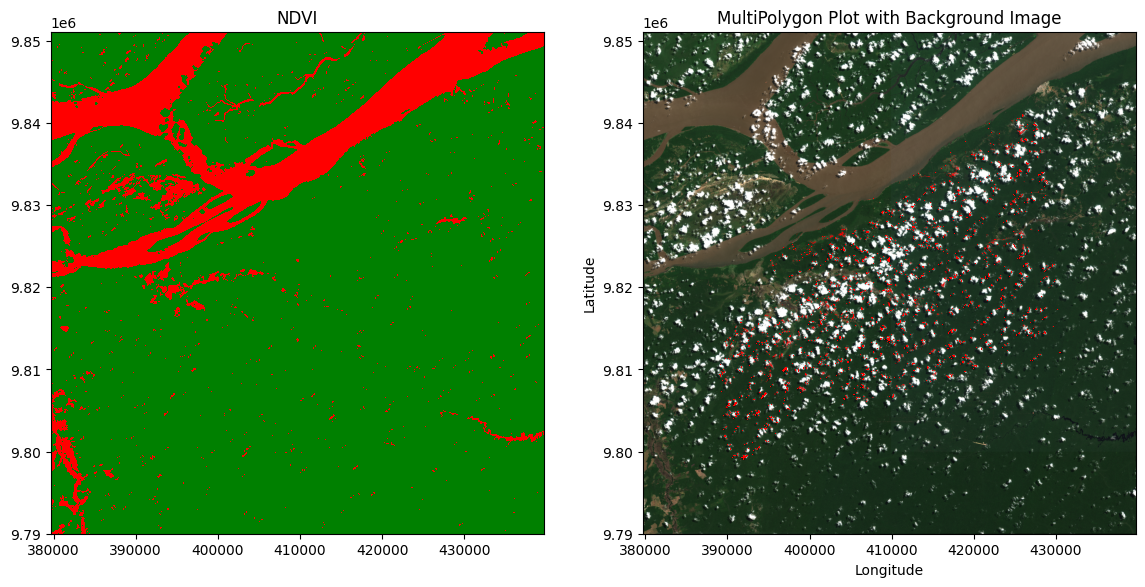

In [45]:
gdf_local = gdf[(gdf['analysis_date'] == '2023-08-26')].reset_index(drop=True)

# Caminho para a imagem
image_path = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/TCI_merged.tiff"
image_path_B04 = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/B04_merged.tiff"
image_path_B08 = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/B08_merged.tiff"
image_path_SCL = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/SCL_merged.tiff"

# Ler a imagem usando rasterio
with rasterio.open(image_path) as src:
    image = src.read([1, 2, 3]).transpose(1,2,0)  # Ler as três primeiras bandas (RGB)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    image_crs = src.crs  # Sistema de coordenadas da imagem
gdf_local= gdf_local.to_crs(image_crs)
# Sistema de coordenadas dos polígonos (supondo que seja WGS84)
#polygons_crs = 'EPSG:4326'

# Criar um transformador para converter as coordenadas
#transformer = Transformer.from_crs(polygons_crs, image_crs, always_xy=True)

# Função para transformar as coordenadas dos polígonos
#def transform_polygon(polygon):
#    return transform(transformer.transform, polygon)

# Supondo que row['geometry'] seja um objeto MultiPolygon
#multipolygon = gdf_awa['geometry'][0]

# Criar uma figura e um eixo
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plotar a imagem de fundo
ax[1].imshow(np.squeeze(image), extent=extent)
        
del image #Libera memória        

#Abre a bandas 4 e 8 e calcula o NDVI
with rasterio.open(image_path_B04) as src:
    B04 = src.read(1).astype(float)
    B04 = B04.clip(min=0)
    #B04 = np.nan_to_num(B04,nan=0.0,posinf=0.0,neginf=0.0)
    B04_transform = src.transform
    B04_crs = src.crs
    print(f"B04 Max: {B04.max()} e Min: {B04.min()}")
    
with rasterio.open(image_path_B08) as src:
    B08 = src.read(1).astype(float)
    B08 = B08.clip(min=0)
    #B08 = np.nan_to_num(B08,nan=0.0,posinf=0.0,neginf=0.0)
    print(f"B08 Max: {B08.max()} e Min: {B08.min()}")
    
with rasterio.open(image_path_SCL) as scl_src:
    SCL = scl_src.read(1)
    #print(SCL.shape)
    # Reamostrar SCL para resolução de 10m
    scl_resampled = np.empty_like(B04, dtype=SCL.dtype)
    reproject(
        source=SCL,
        destination=scl_resampled,
        src_transform=scl_src.transform,
        src_crs=scl_src.crs,
        dst_transform=B04_transform,
        dst_crs=B04_crs,
        resampling=Resampling.nearest
    )

def calculate_ndvi(nir, red, epsilon=1e-10):
    """
    Calcula o NDVI (Normalized Difference Vegetation Index).

    Args:
    nir (numpy array): Reflectância no infravermelho próximo.
    red (numpy array): Reflectância no vermelho.
    epsilon (float): Pequena constante para evitar divisão por zero.

    Returns:
    numpy array: NDVI.
    """
    ndvi = (nir - red) / (nir + red + epsilon)
    return ndvi

    
# Calcular o NDVI
NDVI = calculate_ndvi(B08, B04)

del B04, B08, SCL #Libera memória

# Identificar pixels do SCL com valores 0, 3, 8 e 9
mask_values = [0, 3, 8, 9]
mask = np.isin(scl_resampled, mask_values)

NDVI[mask] = 1

# Definir o colormap personalizado: azul para valores negativos, preto para 0-0.35, gradiente para o resto
colors = ['red', 'green','white']  # Cores para cada faixa
bounds = [-1, 0.36, 1.1, 2]  # Intervalos dos valores de NDVI
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plotar o NDVI
ax[0].imshow(NDVI, cmap=cmap, norm=norm, extent=extent)
'''
for i in range(len(gdf_local)):
    multipolygon = gdf_local['geometry'][i] 
    transformed_multipolygon = multipolygon
    # Transformar os polígonos para o sistema de coordenadas da imagem
    #transformed_multipolygon = MultiPolygon([transform_polygon(polygon) for polygon in multipolygon.geoms])

    color = 'red'

    if gdf_local['is_valid'][i] == True:
        color = 'blue'
    # Plotar cada polígono no MultiPolygon transformado
    for polygon in transformed_multipolygon.geoms:
        x, y = polygon.exterior.xy
        ax[0].plot(x, y, color=color)
        ax[1].plot(x, y, color=color)
        #print(x, y)
'''
#gdf_local.plot(ax=ax[0], color='red')
gdf_local.plot(ax=ax[1], color='red')
# Configurar os eixos
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax[1].set_title('MultiPolygon Plot with Background Image')
ax[0].set_title('NDVI')
# Mostrar o gráfico
plt.show()